# RegTech - CS x Sia Partners

In [9]:
# Global imports
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
np.random.seed(23)

# Local imports
from regtech.datalab.dataops.models.mapping.commit2test import Commit2Test

In [12]:
# Util functions
def scatter_plot(x: np.ndarray, y: np.ndarray, title: str) -> None:
    
    plt.scatter(x, y, s=45, c="g", alpha=0.5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()

def plot_roc(y_got: np.ndarray, y_hat: np.ndarray, i) -> None:
    
    # True positive false positive and row auc.
    fpr, tpr, _ = roc_curve(y_got, y_hat)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic (ROC) for test #{i}')
    plt.legend(loc="lower right")
    plt.show()
    

In [3]:
# Parameter simulation
n_tests = 100
n_issue_keys = 1000
n_commit_by_issue_key = 10 
dim_commit_embedding, n_commit_centers = 200, 500
ratio_active_test = 0.03

## 1 - Generate fake data

### Generate Ground of truth

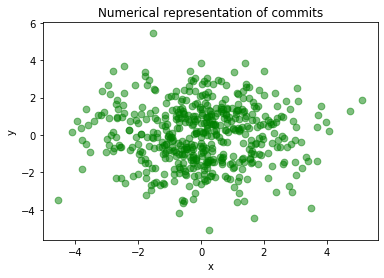

100 has been randomly generated and associated with commit center


In [5]:
# Build commit center represnetation and tests associated
ax_commit_centers = np.random.randn(n_commit_centers, dim_commit_embedding)
ax_tests = np.random.binomial(1, ratio_active_test, (n_commit_centers, n_tests)).astype(bool)

# Reduce dim for visualisation
pca = PCA(n_components=2)
pca.fit(ax_commit_centers)
ax_reduce_commit_centers = pca.transform(ax_commit_centers)

# Scatter plot 
scatter_plot(ax_reduce_commit_centers[:, 0], ax_reduce_commit_centers[:, 1], 'Numerical representation of commits')
print(f'{n_tests} has been randomly generated and associated with commit center')

### Generate training dataset

In [6]:
# Build feature
l_commits, l_tests = [], [] 
for _ in range(n_issue_keys):
    l_group_commits, ax_group_tests = [], np.zeros(n_tests, dtype=bool)
    for _ in range(n_commit_by_issue_key):
        i = np.random.choice(np.arange(n_commit_centers))
        l_group_commits.append(ax_commit_centers[i, :])
        ax_group_tests += ax_tests[i]

    l_commits.append(np.stack(l_group_commits))
    l_tests.append(ax_group_tests)
    

# build train and test database
X, y = np.stack(l_commits), np.stack(l_tests)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(f"{X_train.shape[0]} samples has been sampled to train the model")
print(f"{X_test.shape[0]} samples has been sampled to test the model")

900 samples has been sampled to train the model
100 samples has been sampled to test the model


### Train model

2021-10-12 19:09:46.221807: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-12 19:09:46.222029: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-12 19:09:46.222053: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-12 19:09:46.222076: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (erepie-X1): /proc/driver/nvidia/version does not exist
2021-10-12 19:09:46.222267: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appro

Epoch 1/1000
23/30 [======================>.......] - ETA: 0s - loss: 0.7277 

2021-10-12 19:09:46.611658: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-12 19:09:46.613518: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1800000000 Hz


30/30 [==============================] - 1s 8ms/step - loss: 0.7062 - val_loss: 0.5717
Epoch 2/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.5636 - val_loss: 0.5659
Epoch 3/1000
30/30 [==============================] - 0s 7ms/step - loss: 0.5493 - val_loss: 0.5471
Epoch 4/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.5364 - val_loss: 0.5464
Epoch 5/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.5262 - val_loss: 0.5354
Epoch 6/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.5125 - val_loss: 0.5251
Epoch 7/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.4986 - val_loss: 0.5099
Epoch 8/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.4855 - val_loss: 0.5073
Epoch 9/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.4733 - val_loss: 0.5014
Epoch 10/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.4574 - val_loss: 0.4958
Epoch 11/100

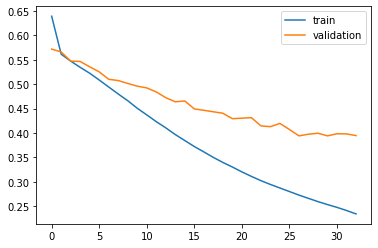

In [7]:
# Instantiate the model
n_kernels, kernel_size = 150, 1
learning_rate = 0.001
nb_epoch = 1000
input_dim, latent_test_dim = X_train.shape[1:], y_train.shape[-1]
c2t_model = Commit2Test(latent_test_dim, n_kernels, kernel_size, input_dim, learning_rate, nb_epoch)

# Fit the model
c2t_model.fit(X, y)


### Evaluate model

We use the AUC of ROC which qualify the quality of prediction from a recall and precision percpective. An well known empirical evaluation of this metric is

* 0.5 = This suggests no discrimination, so we might as well flip a coin.
* 0.5-0.7 = We consider this poor discrimination, not much better than a coin toss.
* 0.7-0.8 = Acceptable discrimination
* 0.8-0.9= Excellent discrimination
* \>0.9 = Outstanding discrimination"

The AUC score is 0.9573694260935262 on train
The AUC score is 0.9564015594277464 on test


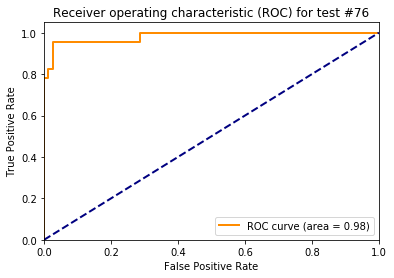

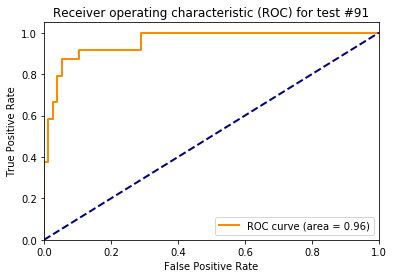

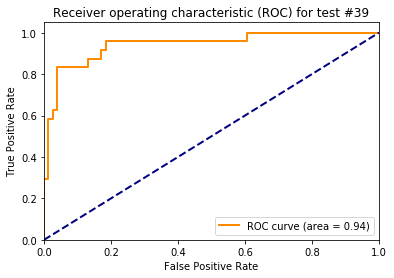

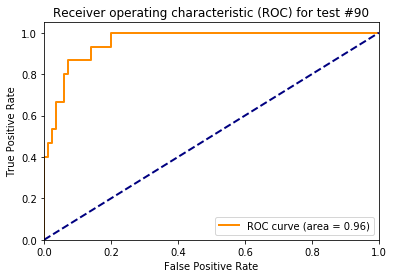

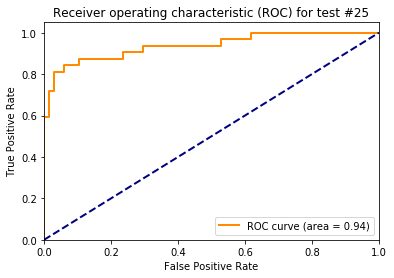

In [13]:
from sklearn.metrics import roc_auc_score
y_train_hat = c2t_model.network.predict(X_train)
y_test_hat = c2t_model.network.predict(X_test)

# Roc AUC curve
print(f'The AUC score is {roc_auc_score(y_train, y_train_hat)} on train')
print(f'The AUC score is {roc_auc_score(y_test, y_test_hat)} on test')


# random ROC from test
for i in np.random.choice(np.arange(y_test.shape[1]), 5):
    plot_roc(y_test[:, i], y_test_hat[:, i], i)


# Real test example



